# Importamos las librerías necesarias

In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.types as typ
from pyspark.ml.feature import StringIndexer
import pyspark.ml.feature as ft
import numpy as np
import pyspark.ml.classification as cl
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.functions import when, lit
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from platform import python_version

print(python_version())

3.6.13


In [3]:
from sklearn import metrics


In [4]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
spark = SparkSession(sc)

## Creamos las labels para el schema y el vector assembler

In [6]:
labels = [
    ('isFraud', typ.IntegerType()),
    ('step', typ.IntegerType()),
    ('d_amount', typ.IntegerType()),
    ('d_oldbalanceOrg', typ.IntegerType()),
    ('d_newbalanceOrig', typ.IntegerType()),
    ('d_oldbalanceDest', typ.IntegerType()),
    ('d_newbalanceDest', typ.IntegerType()),
    ('isFlaggedFraud', typ.IntegerType()),
    ('PAYMENT', typ.IntegerType()),
    ('TRANSFER', typ.IntegerType()),
    ('CASH_IN', typ.IntegerType()),
    ('CASH_OUT', typ.IntegerType()),
    ('DEBIT', typ.IntegerType())
]
schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])


In [7]:
labels[2:7]

[('d_amount', IntegerType),
 ('d_oldbalanceOrg', IntegerType),
 ('d_newbalanceOrig', IntegerType),
 ('d_oldbalanceDest', IntegerType),
 ('d_newbalanceDest', IntegerType)]

In [8]:
df = spark.read.csv('fraude2.csv', 
                        header=True, 
                        inferSchema = 'true')

In [9]:
df.show(3)

+---+----+--------+------+-----------+-------------+--------------+----------+--------------+--------------+-------+--------------+
|_c0|step|    type|amount|   nameOrig|oldbalanceOrg|newbalanceOrig|  nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+---+----+--------+------+-----------+-------------+--------------+----------+--------------+--------------+-------+--------------+
|  2|   1|TRANSFER| 181.0|C1305486145|        181.0|           0.0|C553264065|           0.0|           0.0|      1|             0|
|  3|   1|CASH_OUT| 181.0| C840083671|        181.0|           0.0| C38997010|       21182.0|           0.0|      1|             0|
|251|   1|TRANSFER|2806.0|C1420196421|       2806.0|           0.0|C972765878|           0.0|           0.0|      1|             0|
+---+----+--------+------+-----------+-------------+--------------+----------+--------------+--------------+-------+--------------+
only showing top 3 rows



In [10]:
df.select('type').distinct().collect()

[Row(type='TRANSFER'),
 Row(type='CASH_IN'),
 Row(type='CASH_OUT'),
 Row(type='PAYMENT'),
 Row(type='DEBIT')]

In [11]:
tipo = df.type

## Creamos las dummies del tipo de pago

In [12]:
df2 = df.withColumn("PAYMENT",
                     when((df.type == "PAYMENT"), lit(1)).otherwise(lit(0)))

df2 = df2.withColumn("TRANSFER",
                     when((df2.type == "TRANSFER"), lit(1)).otherwise(lit(0)))
df2 = df2.withColumn("CASH_IN",
                     when((df2.type == "CASH_IN"), lit(1)).otherwise(lit(0)))
df2 = df2.withColumn("CASH_OUT",
                     when((df2.type == "CASH_OUT"), lit(1)).otherwise(lit(0)))
df2 = df2.withColumn("DEBIT",
                     when((df2.type == "DEBIT"), lit(1)).otherwise(lit(0)))

In [13]:
df2.show(2)

+---+----+--------+------+-----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-------+--------+-------+--------+-----+
|_c0|step|    type|amount|   nameOrig|oldbalanceOrg|newbalanceOrig|  nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|PAYMENT|TRANSFER|CASH_IN|CASH_OUT|DEBIT|
+---+----+--------+------+-----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-------+--------+-------+--------+-----+
|  2|   1|TRANSFER| 181.0|C1305486145|        181.0|           0.0|C553264065|           0.0|           0.0|      1|             0|      0|       1|      0|       0|    0|
|  3|   1|CASH_OUT| 181.0| C840083671|        181.0|           0.0| C38997010|       21182.0|           0.0|      1|             0|      0|       0|      0|       1|    0|
+---+----+--------+------+-----------+-------------+--------------+----------+--------------+--------------+-------+--------------+-------+-

## Eliminamos las variables identificadoras

In [14]:
df3 = df2.drop('nameOrig')
df3 = df3.drop('nameDest')

## Discretizamos

In [15]:
discretizer1 = ft.QuantileDiscretizer(
numBuckets = 32,
inputCol = 'amount',
outputCol = 'd_amount')

discretizer2 = ft.QuantileDiscretizer(
numBuckets = 32,
inputCol = 'oldbalanceOrg',
outputCol = 'd_oldbalanceOrg')

discretizer3 = ft.QuantileDiscretizer(
numBuckets =  32,
inputCol = 'newbalanceOrig',
outputCol = 'd_newbalanceOrig')

discretizer4 = ft.QuantileDiscretizer(
numBuckets = 32,
inputCol = 'oldbalanceDest',
outputCol = 'd_oldbalanceDest')
discretizer5 = ft.QuantileDiscretizer(
numBuckets = 32,
inputCol = 'newbalanceDest',
outputCol = 'd_newbalanceDest')
result = discretizer1.fit(df3).transform(df3)
result = discretizer2.fit(result).transform(result)
result = discretizer3.fit(result).transform(result)
result = discretizer4.fit(result).transform(result)
df3 = discretizer5.fit(result).transform(result)

In [16]:
df3.agg({'d_amount': 'max',
               'd_oldbalanceDest': 'max',
               'd_newbalanceDest':'max'}).show()

+---------------------+-------------+---------------------+
|max(d_oldbalanceDest)|max(d_amount)|max(d_newbalanceDest)|
+---------------------+-------------+---------------------+
|                 18.0|         31.0|                 20.0|
+---------------------+-------------+---------------------+



## Creamos el Vector Assembler y dividimos el Dataframe

In [17]:
featuresCreator = ft.VectorAssembler(
    inputCols=[
        col[0] 
        for col 
        in labels[1:]],
    outputCol='features'
)

In [18]:
normalizer = ft.StandardScaler(
    inputCol=featuresCreator.getOutputCol(), 
    outputCol='normalized', 
    withMean=True,
    withStd=True
)

In [19]:
train, test = df3.randomSplit([0.7, 0.3], seed=666)

In [20]:
def confusion_matrix(df):
    tp = df[(df.isFraud == 1) & (df.prediction == 1)].count()
    tn = df[(df.isFraud == 0) & (df.prediction == 0)].count()
    fp = df[(df.isFraud == 0) & (df.prediction == 1)].count()
    fn = df[(df.isFraud == 1) & (df.prediction == 0)].count()
    return [[tp,fp],[fn,tn]]

# Regresión logística

In [21]:
logistic = cl.LogisticRegression(
    maxIter=10, 
    regParam=0.01, 
    labelCol='isFraud')

In [22]:
pipeline = Pipeline(stages=[featuresCreator,normalizer,logistic])

In [23]:
model = pipeline.fit(train)

In [24]:
test_model = model.transform(test)

In [25]:
evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='isFraud')

In [26]:
print(evaluator.evaluate(test_model, 
     {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.9813909911674834
0.8319054839535748


In [27]:
confusion_matrix1 = confusion_matrix(test_model)

In [28]:
confusion_matrix1

[[992, 0], [1533, 106752]]

<AxesSubplot:>

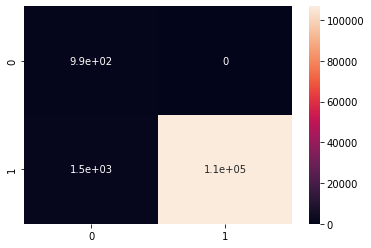

In [29]:
sns.heatmap(confusion_matrix1, annot=True)

Como podemos observar a pesar de no tener falsos negativos (0,1), tenemos un gran número de falsos positivos (1,0)

In [30]:
!pip install pyspark.ml.functions

ERROR: Could not find a version that satisfies the requirement pyspark.ml.functions (from versions: none)
ERROR: No matching distribution found for pyspark.ml.functions


In [31]:
y_pred1 = test_model.select(test_model.prediction)
y_true1 = test_model.select(test_model.isFraud)

In [32]:
y_true1.show(2)

+-------+
|isFraud|
+-------+
|      1|
|      1|
+-------+
only showing top 2 rows



In [33]:
evaluatorMulti = MulticlassClassificationEvaluator()
evaluatorMulti = ev.MulticlassClassificationEvaluator(labelCol='isFraud')
evaluatorMulti.evaluate(test_model)

0.9829640287960112

In [34]:
evaluatorMulti.evaluate(test_model, {evaluator.metricName: "recall"})

0.9829640287960112

In [35]:
evaluatorMulti.evaluate(test_model, {evaluator.metricName: "accuracy"})

0.9829640287960112

In [36]:
evaluatorMulti.evaluate(test_model, {evaluator.metricName: "prescision"})

0.9829640287960112

Como podemos observar el modelo de regresión logística presenta resultados demasiado buenos, por lo que probablemente presente overfitting o sea debido al desbalance de los datos

# Random Forest

In [37]:
rf = RandomForestClassifier(labelCol="isFraud", featuresCol='features', numTrees=96)

In [38]:
pipeline2 = Pipeline(stages=[featuresCreator,normalizer,rf])

In [39]:
model2 = pipeline2.fit(train)

In [40]:
test_model2 = model2.transform(test)

In [41]:
print(evaluator.evaluate(test_model2, 
     {evaluator.metricName: 'areaUnderROC'}))

print(evaluator.evaluate(test_model2, {evaluator.metricName: 'areaUnderPR'}))



0.9949001275464767
0.9492899917293788


In [42]:
confusion_matrix2 = confusion_matrix(test_model2)

In [43]:
confusion_matrix2

[[2036, 26], [489, 106726]]

In [44]:
confusion_matrix2

[[2036, 26], [489, 106726]]

<AxesSubplot:>

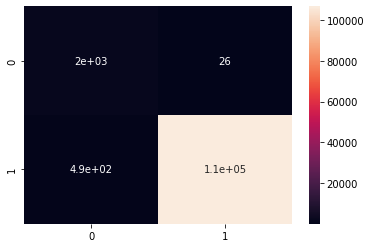

In [45]:
sns.heatmap(confusion_matrix2, annot=True)

En este caso tenemos un mejor número de falsos positivos y falsos negativos, si comparamos con el algoritmo anterior.

In [46]:
evaluatorMulti.evaluate(test_model2)

0.9950544562140451

In [47]:
evaluatorMulti.evaluate(test_model2, {evaluator.metricName: "recall"})

0.9950544562140451

In [48]:
evaluatorMulti.evaluate(test_model2, {evaluator.metricName: "accuracy"})

0.9950544562140451

In [49]:
evaluatorMulti.evaluate(test_model2, {evaluator.metricName: "prescision"})

0.9950544562140451

Al igual que con la regresión logística, deberíamos fijarnos solo en la matriz de confusión para evaluar el modelo debido al desbalance de los datos

# Gradient Boost Classifier


In [50]:
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)

In [51]:
pipeline3 = Pipeline(stages=[featuresCreator,normalizer,gbt])

In [52]:
model3 = pipeline3.fit(train)

In [53]:
test_model3 = model3.transform(test)

In [54]:
print(evaluator.evaluate(test_model3, 
     {evaluator.metricName: 'areaUnderROC'}))

print(evaluator.evaluate(test_model3, {evaluator.metricName: 'areaUnderPR'}))


0.9972061997679087
0.9638888975289519


In [59]:
confusion_matrix3 = confusion_matrix(test_model3)

In [60]:
confusion_matrix3

[[2242, 57], [283, 106695]]

<AxesSubplot:>

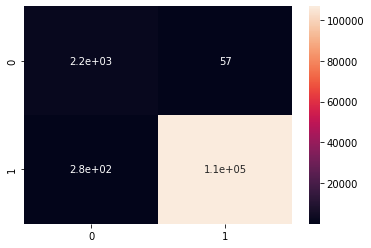

In [61]:
sns.heatmap(confusion_matrix3, annot=True)

Al igual que con el random forest este algoritmo presenta muy buenos resultados

In [62]:
evaluatorMulti.evaluate(test_model3, {evaluator.metricName: "recall"})

0.9968174036125416

In [63]:
evaluatorMulti.evaluate(test_model3, {evaluator.metricName: "accuracy"})

0.9968174036125416

In [64]:
evaluatorMulti.evaluate(test_model3, {evaluator.metricName: "prescision"})

0.9968174036125416

# Aplicamos ajuste de hiperparámetros a los modelos

## Random Forest

In [65]:
rf2 = RandomForestClassifier(labelCol="isFraud", featuresCol='features', numTrees=96)
grid = tune.ParamGridBuilder().addGrid(rf2.numTrees, [96, 192, 384]).addGrid(rf2.maxDepth, [5, 6, 7]).build()

In [66]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='isFraud')

In [67]:
cv = tune.CrossValidator(estimator=rf2, estimatorParamMaps=grid, evaluator=evaluator)

In [68]:
pipeline4 = Pipeline(stages=[featuresCreator])
data_transformer = pipeline4.fit(train)

In [ ]:
cvModel = cv.fit(data_transformer.transform(train))

In [ ]:
data_train = data_transformer.transform(births_test)
results = cvModel.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

In [ ]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cvModel.getEstimatorParamMaps(), 
        cvModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

## Gradient Boost

In [ ]:
gbt2 = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)
grid = tune.ParamGridBuilder().addGrid(gbt2.maxIter, [5, 10, 20]).build()

In [ ]:
cv = tune.CrossValidator(estimator=gbt2, estimatorParamMaps=grid, evaluator=evaluator)

In [ ]:
pipeline4 = Pipeline(stages=[featuresCreator])
data_transformer = pipeline4.fit(train)

In [ ]:
cvModel = cv.fit(data_transformer.transform(train))

In [ ]:
data_train = data_transformer.transform(test)
results = cvModel.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

In [ ]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cvModel.getEstimatorParamMaps(), 
        cvModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

En el caso del gradient boost parce indiferente el número de iteraciones

## Aplicamos PCA para ver si mejora el modelo

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=6, inputCol='features', outputCol='pcaFeatures')
gbt = GBTClassifier(labelCol="isFraud", featuresCol="pcaFeatures", maxIter=10)

pipelinepca= Pipeline(stages=[featuresCreator, pca, gbt])
modelpca = pipelinepca.fit(train).transform(test)

In [ ]:
confusion_matrix5 = confusion_matrix(modelpca)

In [ ]:
confusion_matrix5

Como podemos observar no encontramos una mejoría notable, además perdemos interpretabilidad por lo que definitivamente no merece la pena aplicar PCA

# Conclusiones

Tanto el random forest como el gradient boost presentan buenos datos en la matrix de confusión. Sería conveniente probar con datos más balanceados o algoritmos más potentes como una red neuronal. A pesar de ello podemos decir que son buenos modelos que pueden ser aplicados.

Link presentación: https://view.genial.ly/6282aa29c84f020011302951/interactive-image-imagen-interactiva